In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [27]:
degree = 5
n_nodes = 20
rate = 0.3
T = 8
dt = 0.01
fprefix = 'data/rrg_sis_'
train_sample = 50000
val_sample = 1000


In [28]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
# Generating the time series
continue_simu = False
iter_max = 100
i = 0



#if os.path.exists(fprefix + '_states.b'):
#    os.remove(fprefix + '_states.b')
data = {}
idx = 0
while(i < train_sample):
    data[idx] = []
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt, filename=None,
                                    full_data_mode=True, overwrite=True)
    t = 0
    while(t < T and sisnet.continue_simu and i < train_sample):
        t += dt
        sisnet.update(record=False)
        i += 1
        data[idx].append(sisnet.activity)
    idx += 1

f = open(fprefix + 'states.b', 'wb')
pickle.dump(data, f)
f.close()

%reset_selective -f data

In [29]:
transform = [dl.SIS_StateToFloat(), dl.ResizeData((n_nodes, 1))]

dataset = dl.Markov_Dataset(fprefix + 'states.b', pre_transform=transform)

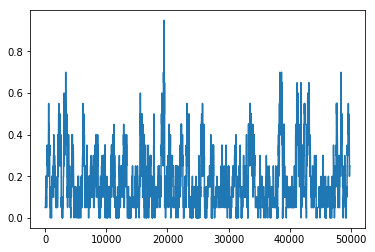

In [30]:
def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_train_dataset(dataset)
plt.plot(avg)
plt.show()

In [32]:
n_hidden = [4, 2]
n_embedding = 1
optimizer = lambda p: torch.optim.Adam(p, lr=1e-3, weight_decay=1e-3)
use_cuda = True
loss = torch.nn.BCELoss(reduction='sum')



markov_cvae = dl.Markov_Node_CVAE(graph, n_hidden, n_embedding, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

In [33]:
new_lr = 1e-3
for g in markov_cvae.optimizer.param_groups:
    g['lr'] = new_lr

In [35]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])
markov_cvae.fit(train_dataset, None,
                epochs=10,
                batch_size=128,
                metrics=["recon", "kl_div"],
                show_var=False)

New best Epoch: 21 - Time: 7.71
	 Train. - loss: 0.4648, recon: 0.4648, kl_div: 0.0000, 
New best Epoch: 22 - Time: 6.05
	 Train. - loss: 0.4627, recon: 0.4627, kl_div: 0.0000, 
New best Epoch: 23 - Time: 5.84
	 Train. - loss: 0.4612, recon: 0.4612, kl_div: 0.0000, 
New best Epoch: 24 - Time: 6.07
	 Train. - loss: 0.4550, recon: 0.4550, kl_div: 0.0000, 
New best Epoch: 25 - Time: 6.06
	 Train. - loss: 0.4542, recon: 0.4542, kl_div: 0.0000, 
New best Epoch: 26 - Time: 5.96
	 Train. - loss: 0.4540, recon: 0.4540, kl_div: 0.0000, 
New best Epoch: 27 - Time: 6.01
	 Train. - loss: 0.4539, recon: 0.4539, kl_div: 0.0000, 
Epoch: 28 - Time: 5.95
	 Train. - loss: 0.4539, recon: 0.4539, kl_div: 0.0000, 
New best Epoch: 29 - Time: 6.12
	 Train. - loss: 0.4538, recon: 0.4538, kl_div: 0.0000, 
New best Epoch: 30 - Time: 6.10
	 Train. - loss: 0.4537, recon: 0.4537, kl_div: 0.0000, 


In [36]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]
    t = 0
    states, z, past_states = learned_model.predict(init_states, batch_size=2)    
    learned_avg = [np.mean(states)]
    
    while(t < T):
        t += dt
        states, z, past_states = learned_model.predict(past_states, batch_size=2)

        learned_avg.append(np.mean(states))
        states = torch.bernoulli(torch.tensor(states[0]))
        past_states = states
    
    return learned_avg

def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

def show_dataset(dataset):
    avg = []
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [37]:
null_cvae = dl.Markov_Node_CVAE(graph, n_hidden, n_embedding, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
trained_ts = test_model(markov_cvae, dataset)
untrained_ts = test_model(null_cvae, dataset)

#avg_ts = show_train_dataset(dataset)


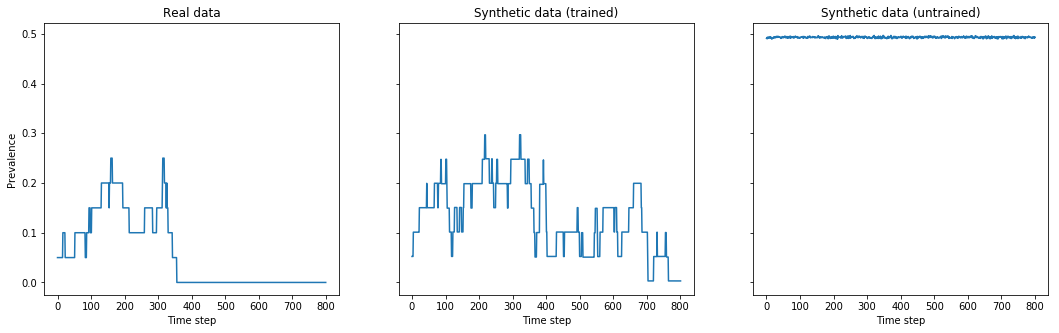

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

ax[2].plot(untrained_ts)
ax[2].set_title('Synthetic data (untrained)')
ax[2].set_xlabel('Time step')

#fig.savefig('fig/png/nodemodel_test_rrgsis_d5_n100_rate0.4.png')
#fig.savefig('fig/pdf/nodemodel_test_rrgsis_d5_n100_rate0.4.pdf')
plt.show()

In [40]:
def reconstruction_dataset(model, dataset, verbose=True):
    learned = np.zeros(len(dataset))
    real = np.zeros(len(dataset))
    
    for i, d in enumerate(dataset):
        
        if i%1000==0 and verbose: print(str(i) + "/" + str(len(dataset)))
        present, past = d
        sample, _, _ = model.predict(past, batch_size=2)
        learned[i] = np.mean(sample)
        real[i] = np.mean(present.numpy())
        
    return real, learned
        
    

In [41]:
real, learned = reconstruction_dataset(markov_cvae, dataset, False)

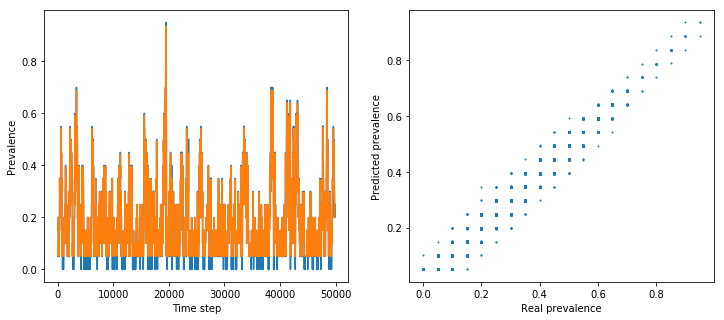

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real, '-')
ax[0].plot(learned, '-')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')

ax[1].plot(real, learned, '.', markersize=2)
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Predicted prevalence')
plt.show()
